<a href="https://colab.research.google.com/github/knwin/Detect-palmtrees-with-Yolo-and-ImageAI/blob/main/Palm_tree_detection_on_large_aerial_imagery_with_yolov3_and_ImageAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

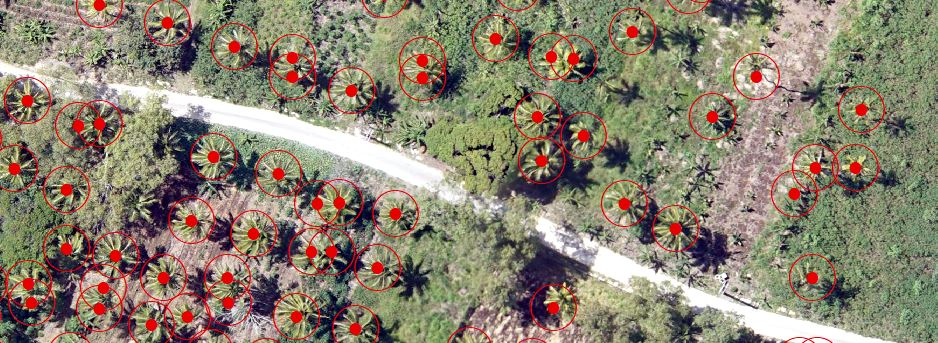

# Palm Tree detection with YoloV3 and ImageAI
------
A YoloV3 model is trained for Paltm tree detection in Aerial Mosaic. Training and testimages are prepared in advance and downloaded into this notebook for training.

[ImageAI](https://imageai.readthedocs.io/en/latest/index.html) module is used to train YoloV3 model in this work.

Custom Model training and detection was inspried by [Object Detection with 10 lines of code](https://towardsdatascience.com/object-detection-with-10-lines-of-code-d6cb4d86f606) and [Train Object Detection AI with 6 lines of code](https://medium.com/deepquestai/train-object-detection-ai-with-6-lines-of-code-6d087063f6ff) written by **Moses Olafenwa**.

Persons like me with none-computer science background are usually afraid to touch the subjects like ML and Deep Learning as there are too many unknown for us. But **Moses Olafenwa's** articles encouraged me to taste Deep Learning coding. 

ImageAI seems to take care of many hyperparameter settings in the background and that attract people like me who are scared by buzz words "hyper perameters, loss, gradient decent, neurons etc". 
 
The application of Deeplearning model in Geospatial field is inspired by ESRI's "Use deep learning to assess palm tree health" [tutorial notebook](https://learn.arcgis.com/en/projects/use-deep-learning-to-assess-palm-tree-health/). ESRI tutorial uses SSD model with its own arcgis.learn module on ArcGIS Pro without a line of codes.



-------
```
Author: 

Kyaw Naing Win
```
[LinkedIn Profile](https://www.linkedin.com/in/kyaw-naing-win-90204b34/)

-------
Credits: 

Deeplearning Model & code: ImageAI's [Custom Detection Model Training](https://github.com/OlafenwaMoses/ImageAI/blob/master/imageai/Detection/Custom/CUSTOMDETECTIONTRAINING.md)

UAV Image source: [Open Aerial Map](https://openaerialmap.org/)

## Setup

### Install dependencies and ImageAI module

In [ ]:
!pip install imageai --upgrade

### Use GPU to speed up the training on Colab
Change to GPU from Runtime menu > Change Runtime type.

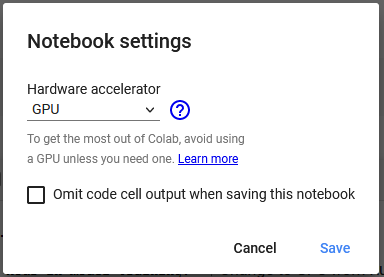

Note: even with GPU on colab, it could take about two hour in model training.

### Load necessary modules

In [4]:
from imageai.Detection.Custom import DetectionModelTrainer
from imageai.Detection.Custom import CustomObjectDetection
from google_drive_downloader import GoogleDriveDownloader as gdd
from osgeo import gdal
import numpy as np
import pandas as pd
import os
from PIL import Image
import datetime


## Get training and test image datsets
UAV Imagery Mosaic is downloaded from [Open Aerial Map](https://openaerialmap.org/) site. For model training, some parts of the UAV mosaic is sliced into 448 x 448 pixels image chips and labeled with [LabelImg](https://github.com/tzutalin/labelImg) and organized in folder structure required by [ImageAI](https://imageai.readthedocs.io/en/latest/index.html). 
```
>> train    >> images       >> img_1.jpg  (shows Object_1)
            >> images       >> img_2.jpg  (shows Object_2)
            >> images       >> img_3.jpg  (shows Object_1, Object_3 and Object_n)
            >> annotations  >> img_1.xml  (describes Object_1)
            >> annotations  >> img_2.xml  (describes Object_2)
            >> annotations  >> img_3.xml  (describes Object_1, Object_3 and Object_n)

>> validation   >> images       >> img_151.jpg (shows Object_1, Object_3 and Object_n)
                >> images       >> img_152.jpg (shows Object_2)
                >> images       >> img_153.jpg (shows Object_1)
                >> annotations  >> img_151.xml (describes Object_1, Object_3 and Object_n)
                >> annotations  >> img_152.xml (describes Object_2)
                >> annotations  >> img_153.xml (describes Object_1)
``` 
In this exercise, there is only one object annotated in the training images i.e palm_tree

This dataset is zipped and uploaded to my google drvie from which I have shared for public use in this notebook.

The training dataset will be downloaded to current colab space. You can check in the folder structure under File menu once below code is run.

In [11]:
#  download training images
gdd.download_file_from_google_drive(file_id='1HemNGDOSXSYOM1bh5OrYuA88GUq3n4_k',
                                    dest_path='./Palmtrees/images.zip',
                                    unzip=True)

### View a few training images

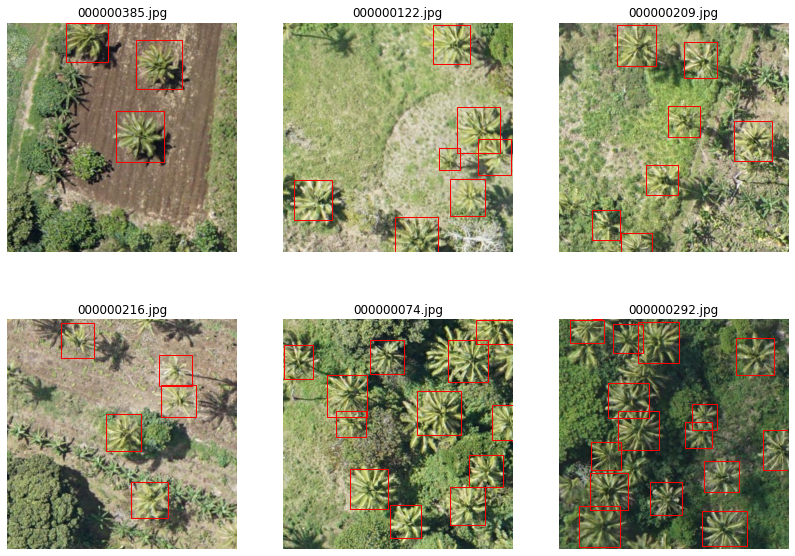

In [1]:
from Palmtrees.python.utilities import view_images
view_images("./Palmtrees/train/images","./Palmtrees/train/annotations")

### Get pre-trained model for transfer learning

This custom training will use weights from previous trained model from ImageAI site, which will reduce training time and produce better model with smaller training dataset.




In [ ]:
# get pre-trained model to transfer learning
!wget https://github.com/OlafenwaMoses/ImageAI/releases/download/essential-v4/pretrained-yolov3.h5

### Model parameter configuration & training
for better accuracy, use epoch number 30 - 50

Larger batch size value will produce better model but the size is subject to RAM size.

In [ ]:
data_directory = "Palmtrees"
object_names = ["palm_tree"]
batch_size = 8 # you can change 4, 8, 16 etc but subject to RAM available.
epochs = 30 # 30 - 50 is ok here
pretrained_model = "pretrained-yolov3.h5" # transfer learning from pre trained model from ImageAI

In [ ]:
trainer = DetectionModelTrainer()
trainer.setModelTypeAsYOLOv3()
trainer.setDataDirectory(data_directory=data_directory)
trainer.setTrainConfig(object_names_array=object_names, batch_size=batch_size, num_experiments=epochs, train_from_pretrained_model=pretrained_model)
trainer.trainModel()

### Model evaluation
Read ImageAI documentation for detial. You can skip it now and try later.

In [ ]:
# evaluate saved models
metrics = trainer.evaluateModel(
    model_path="./Palmtrees/models", 
    json_path="./Palmtrees/json/detection_config.json", 
    iou_threshold=0.5, 
    object_threshold=0.3, 
    nms_threshold=0.5,
    compile=False
    )
print(metrics)

### Models saved during the training
ImageAI save models after each epoch if the model loss is better than previous one. Usually the last save model is the best one. Below code will list all the saved models under ***Palmtrees/models*** folder.

In [ ]:
my_models= [x for x in os.listdir('./Palmtrees/models')]
my_models.sort()
print (my_models)
last_model = my_models[-1:][0]
print("\nlast_model name: ", last_model)

['detection_model-ex-001--loss-0086.198.h5', 'detection_model-ex-002--loss-0056.307.h5', 'detection_model-ex-003--loss-0048.133.h5', 'detection_model-ex-004--loss-0045.619.h5', 'detection_model-ex-005--loss-0042.916.h5', 'detection_model-ex-006--loss-0041.268.h5', 'detection_model-ex-007--loss-0039.250.h5', 'detection_model-ex-008--loss-0038.851.h5', 'detection_model-ex-009--loss-0036.887.h5', 'detection_model-ex-010--loss-0036.419.h5', 'detection_model-ex-011--loss-0035.889.h5', 'detection_model-ex-012--loss-0035.718.h5', 'detection_model-ex-013--loss-0035.474.h5', 'detection_model-ex-014--loss-0034.425.h5', 'detection_model-ex-015--loss-0033.998.h5', 'detection_model-ex-016--loss-0033.601.h5', 'detection_model-ex-017--loss-0033.305.h5', 'detection_model-ex-018--loss-0032.979.h5', 'detection_model-ex-020--loss-0032.359.h5', 'detection_model-ex-021--loss-0031.250.h5', 'detection_model-ex-023--loss-0031.204.h5', 'detection_model-ex-025--loss-0030.399.h5', 'detection_model-ex-028--loss-0

## Detection model test
Detection model works well on the smaller Image. However it fails on large image like Aerial Photo Mosaic. Therefore testing is tried on small subset of the mosiac image.

In [ ]:
detector = CustomObjectDetection()
detector.setModelTypeAsYOLOv3()
detector.setModelPath(os.path.join("./Palmtrees/models",last_model)) 
detector.setJsonPath("./Palmtrees/json/detection_config.json")
detector.loadModel()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


palm_tree  :  41.841208934783936  :  [569, 0, 632, 32]
palm_tree  :  53.487348556518555  :  [24, 30, 101, 93]
palm_tree  :  33.67684483528137  :  [978, 60, 1032, 102]
palm_tree  :  36.940452456474304  :  [1111, 104, 1176, 146]
palm_tree  :  38.529226183891296  :  [5, 123, 29, 182]
palm_tree  :  51.70485973358154  :  [1211, 125, 1274, 181]
palm_tree  :  35.466933250427246  :  [9, 127, 49, 192]
palm_tree  :  48.037636280059814  :  [500, 193, 568, 256]
palm_tree  :  51.63041949272156  :  [349, 206, 421, 263]
palm_tree  :  30.134335160255432  :  [173, 224, 231, 270]
palm_tree  :  52.508288621902466  :  [32, 235, 87, 276]
palm_tree  :  49.95958209037781  :  [90, 259, 149, 311]
palm_tree  :  51.6523003578186  :  [482, 266, 542, 324]
palm_tree  :  56.94809556007385  :  [340, 284, 393, 349]
palm_tree  :  56.35175704956055  :  [384, 311, 451, 369]
palm_tree  :  52.803218364715576  :  [66, 330, 126, 385]
palm_tree  :  24.615992605686188  :  [3, 351, 26, 412]
palm_tree  :  45.52631080150604  :  [

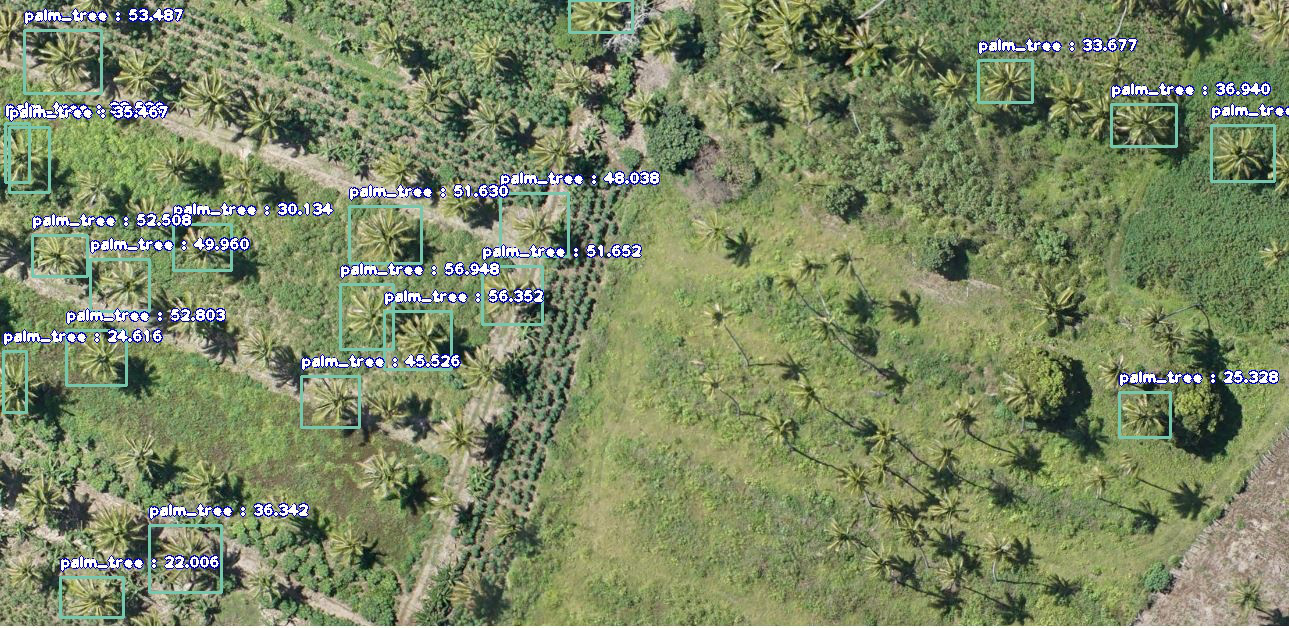

In [ ]:
image = "./Palmtrees/Subset_test.JPG"
image_detected = "./Palmtrees/Subset_test_detected.JPG"

detections = detector.detectObjectsFromImage(
    input_image=image, 
    output_image_path=image_detected, 
    minimum_percentage_probability=20
    )
for detection in detections:
    print(detection["name"], " : ", detection["percentage_probability"], " : ", detection["box_points"])

img = Image.open(image_detected)
img

## Detect palm trees on Aerial photo mosaic

### Download Aerial Imagery Mosaic
This aerial image (UAV mosaic) is downloaded from [XYZ](https://abcd.com) and saved in my google drive for easy download by user of this workbook. You can download your area of interest on ....

In [9]:
#download UAV image
gdd.download_file_from_google_drive(file_id='107Td2m0vjKP1FYPq9fpnEL4UJi0RNIJC',
                                    dest_path='./Palmtrees/Kolovai UAV4R Subset.tif',
                                    unzip=False)

### Load pre-trained model [Option]

If you do not want to wait for 50 epoch training, you can dowload and use the model I have trained already.

Uncomment below codes and run please.

In [5]:

gdd.download_file_from_google_drive(file_id='1HizzMNwkSo6dqn6l9YErEx8lq_RjPhEH',
                                    dest_path='./Palmtrees/pretrained_model/palmtree_model_loss26.zip',
                                    unzip=True)
pretrained_palmtree_model = "./Palmtrees/pretrained_model/detection_model-ex-047--loss-0026.483.h5"
pretrained_palmtree_model_json = "./Palmtrees/pretrained_model/detection_config.json"

detector = CustomObjectDetection()
detector.setModelTypeAsYOLOv3()

detector.setModelPath(pretrained_palmtree_model) 
detector.setJsonPath(pretrained_palmtree_model_json)

detector.loadModel()


### Preparation for detection
Mosaic need to be sliced into smaller tiles and detection is done on each slice. Return bboxes are in pixel coordiantes and therefore converted to real world coordinates base on Coordinate Referece System (CRS) information included in the mosaic image.
Finally results are stored in a csv file.

In [9]:
# detect objects
def detect (detector,image,chip_h,chip_w,prob_thresold,csv_name):

  # Convert pixel coordinates to map coordinates.
  def pixelToMap( pX, pY, geoTransform ):	

    mX = geoTransform[ 0 ] + pX * geoTransform[ 1 ] + pY * geoTransform[ 2 ]
    mY = geoTransform[ 3 ] + pX * geoTransform[ 4 ] + pY * geoTransform[ 5 ]
    
    return mX, mY

  image_detected = "temp.jpg"

  image = gdal.Open(image)
  gt = image.GetGeoTransform() # get georeference parameters

  # Image chips preparation
  image_np_array = np.moveaxis(np.array(image.ReadAsArray()),0,-1) # layer index moved to end
  image_np_array = np.flip(image_np_array,2) # flip RGB order to BGR
  h,w,_ = image_np_array.shape

  # add padding
  pad_right = chip_w - w % chip_w
  pad_bottom = chip_h - h % chip_h
  image_np_array = np.pad(image_np_array,((0,pad_bottom),(0,pad_bottom),(0,0)),mode = 'constant',constant_values=0)

  h,w,_ = image_np_array.shape
  rows = np.arange (0,h,chip_h)
  cols = np.arange (0,w,chip_w)

  print ("detection started:", datetime.datetime.now(),"\n")
  obj_count = 0

  with open(csv_name, 'w') as f:
      f.write("object,probability,lon,lat,width,height,aspect_ratio,area\n")
      for row in rows:
          for col in cols:
              
              offsetX = col
              offsetY = row
              
              image = image_np_array[row:(row+chip_h), col:(col+chip_w), :]
              
              detections = detector.detectObjectsFromImage(
                  input_image=image,
                  input_type = 'array',
                  output_image_path=image_detected, 
                  minimum_percentage_probability=prob_threshold)
              obj_count += len(detections)
              print("\rnumber of object detected: ", obj_count,end="",flush=True)
              for detection in detections:
                  name = detection["name"]
                  x1,y1,x2,y2 = detection["box_points"]
                  x0 = (x1+x2)/2.0
                  y0 = (y1+y2)/2.0
                  w = abs(x1-x2)
                  h = abs(y1-y2)
                  aspect = min(w,h)/max(w,h)
                  x,y = pixelToMap( x0+offsetX, y0+offsetY, gt)
                  prob = detection["percentage_probability"]
                  data = name+","+str(prob)+","+str(x)+","+str(y)+","+str(w)+","+str(h)+","+str(aspect)+","+str(w*h)+"\n"
                  f.write(data)

  print ("\n\ndetection completed: ",datetime.datetime.now(),"\n\n\ndetection results are saved in", csv_name)

### Detect palm trees now!
Detection will be performed on tiles of the image and detection results will be stored in "detection_report.csv".

In [ ]:
image = r"./Palmtrees/Kolovai UAV4R Subset.tif"
chip_h = 448
chip_w = 448
prob_threshold = 25
csv_name = "./Palmtrees/detection_report.csv"

detect(detector,image,chip_h,chip_w,prob_threshold,csv_name)

detection started: 2021-08-10 03:52:57.053837 



/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


number of object detected:  12995

### View detection report (csv table)

width, height and area of detection boxes are in pixels.

In [ ]:
df = pd.read_csv(csv_name)
df.head(10)

# width, height, area are pixels

,object,probability,lon,lat,width,height,aspect_ratio,area
0,palm_tree,44.404030,-175.349023,-21.087060,67,81,0.827160,5427
1,palm_tree,46.373010,-175.349069,-21.087087,69,75,0.920000,5175
2,palm_tree,47.272697,-175.349083,-21.087136,70,59,0.842857,4130
3,palm_tree,55.574340,-175.349176,-21.087154,77,64,0.831169,4928
4,palm_tree,45.506999,-175.348997,-21.087154,69,77,0.896104,5313
5,palm_tree,41.892603,-175.349102,-21.087035,67,41,0.611940,2747
6,palm_tree,39.221886,-175.348908,-21.087066,58,58,1.000000,3364
7,palm_tree,50.235498,-175.349175,-21.087070,60,67,0.895522,4020
8,palm_tree,40.497249,-175.348903,-21.087153,58,70,0.828571,4060
9,palm_tree,49.816051,-175.349114,-21.087173,67,74,0.905405,4958


## View detection results on a map
Results are viewed on a Folium map. Entire UAV mosaic image is not shown in the map to avoid the crash cause by large memory size. Therefore, a smaller subset is overlaid on the map instead.

*aspect_ratio_threshold* & *probability_threshold* filter the results. Only the results that meet these conditions will be placed on the map.

In [ ]:
import folium
from folium import raster_layers

aspect_ratio_threshold = 0.5 # 0 to 1
probability_threshold = 0 # 0 to 1

# subset image for overlaying
w = 5000 # width in pixel
h = 5000 # height in pixel
pX0 = 10000 # upper left corner pixel X
pX1 = pX0 + w
pY0 = 7000 # upper left corner pixel Y
pY1 = pY0 + h
min_lon,max_lat = pixelToMap(pX0,pY0,gt) # upper left coordinates
max_lon,min_lat = pixelToMap(pX1,pY1,gt) # lower right coordinates
image_subset = image_np_array[pY0:pY1, pX0:pX1, :]
image_subset = np.flip(image_subset,2) # from BGR to RGB
image_subset = Image.fromarray (image_subset)
newsize = (int(w/5), int(h/5)) # reduce resolution
image_subset = np.array(image_subset.resize(newsize))

# base folium map
map = folium.Map(
    location=[(min_lat+max_lat)/2, (min_lon + max_lon)/2],
    zoom_start=18,
    #tiles='Esri Satellite'
)

# google earth imagery basemap
tile = folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',        
        attr = 'Google',
        name = 'Google Satellite',
        overlay = False,
        control = True
       ).add_to(map)

# UAV image subset as overlay
map.add_child(raster_layers.ImageOverlay(
        name = "subset image",
        image = image_chip,
        opacity=0.8, 
        bounds =[[min_lat, min_lon], [max_lat, max_lon]])
        )
# Add detected palm trees points as circles
for row in df.iterrows():
  if row[1]['aspect_ratio'] >= aspect_ratio_threshold:
    if row[1]['probability'] > probability_threshold:
      lon = (row[1]['lon'])
      lat = (row[1]['lat'])
      folium.Circle(
        radius=3,
        location=[lat, lon],
        #popup='The Waterfront',
        color='crimson',
        fill=False,
        ).add_to(map)

map

Original ESRI tutorial has sessions for accessing palm tree health using VARI. VARI analysis could be done with python or any desktop GIS and therefore I leave it out here. 

If you want to use the trained model on desktop, download last model (or best model) and json file. Detection on non-GUP desktop/laptop is still fine but trainig on CPU alone will take very long hours even you are using transfer learning from previous trained model from ImageAI. Therefore I would recommend to use Colab or Kaggle where you can access to GPU for model training.

*Happy Deep Learning!*

Kyaw Naing Win